In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#displayed directly within the notebook
%matplotlib inline 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [35]:
# Load the dataset
file_path = 'MarketPricePrediction.csv'
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

       market    month  year  quantity  priceMin  priceMax  priceMod state  \
0  ABOHAR(PB)  January  2005      2350       404       493       446    PB   
1  ABOHAR(PB)  January  2006       900       487       638       563    PB   
2  ABOHAR(PB)  January  2010       790      1283      1592      1460    PB   
3  ABOHAR(PB)  January  2011       245      3067      3750      3433    PB   
4  ABOHAR(PB)  January  2012      1035       523       686       605    PB   

     city          date  
0  ABOHAR  January-2005  
1  ABOHAR  January-2006  
2  ABOHAR  January-2010  
3  ABOHAR  January-2011  
4  ABOHAR  January-2012  


<h2>Data Preprocessing</h2>

In [36]:
# Check for missing values
print(data.isnull().sum())

market      0
month       0
year        0
quantity    0
priceMin    0
priceMax    0
priceMod    0
state       0
city        0
date        0
dtype: int64


<Axes: >

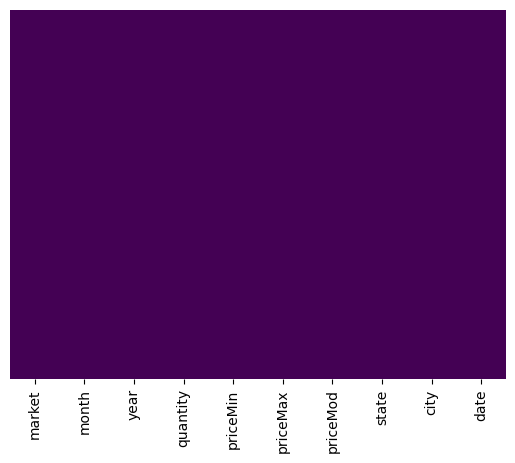

In [37]:
#heatmap to see te null values
sns.heatmap(data.isnull(),yticklabels= False, cbar=False,cmap='viridis')

In [38]:
# Checking duplicate values
data.duplicated().sum()


0

In [39]:
# Inspect a few date to determine the format
print(data['date'].head())

0    January-2005
1    January-2006
2    January-2010
3    January-2011
4    January-2012
Name: date, dtype: object


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10227 entries, 0 to 10226
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
 9   date      10227 non-null  object
dtypes: int64(5), object(5)
memory usage: 799.1+ KB


In [41]:
# Convert the date column to datetime with the correct format
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')

# Set the date column as the index
data.set_index('date', inplace=True)

In [42]:
data

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2005-01-01,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR
2006-01-01,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR
2010-01-01,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR
2011-01-01,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR
2012-01-01,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR
...,...,...,...,...,...,...,...,...,...
2011-12-01,YEOLA(MS),December,2011,131326,282,612,526,MS,YEOLA
2012-12-01,YEOLA(MS),December,2012,207066,485,1327,1136,MS,YEOLA
2013-12-01,YEOLA(MS),December,2013,215883,472,1427,1177,MS,YEOLA


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10227 entries, 2005-01-01 to 2015-12-01
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
dtypes: int64(5), object(4)
memory usage: 799.0+ KB


In [44]:
from sklearn.preprocessing import OneHotEncoder

# Define categorical features
categorical_features = ['market', 'state', 'city']

# Instantiate OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the categorical features
encoded_features = one_hot_encoder.fit_transform(data[categorical_features])

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=data.index)

# Concatenate the encoded DataFrame with the original DataFrame
data_encoded = pd.concat([data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Drop the original categorical features
data_encoded.drop(categorical_features, axis=1, inplace=True)



In [45]:
data

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2005-01-01,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR
2006-01-01,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR
2010-01-01,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR
2011-01-01,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR
2012-01-01,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR
...,...,...,...,...,...,...,...,...,...
2011-12-01,YEOLA(MS),December,2011,131326,282,612,526,MS,YEOLA
2012-12-01,YEOLA(MS),December,2012,207066,485,1327,1136,MS,YEOLA
2013-12-01,YEOLA(MS),December,2013,215883,472,1427,1177,MS,YEOLA


In [46]:
data_encoded

,month,year,quantity,priceMin,priceMax,priceMod,market_ABOHAR(PB),market_AGRA(UP),market_AHMEDABAD(GUJ),market_AHMEDNAGAR(MS),...,city_SRIGANGANAGAR,city_SRINAGAR,city_SRIRAMPUR,city_SURAT,city_TRIVENDRUM,city_UDAIPUR,city_UJJAIN,city_VANI,city_VARANASI,city_YEOLA
0,January,2005,2350,404,493,446,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,January,2006,900,487,638,563,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,January,2010,790,1283,1592,1460,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,January,2011,245,3067,3750,3433,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,January,2012,1035,523,686,605,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10222,December,2011,131326,282,612,526,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10223,December,2012,207066,485,1327,1136,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10224,December,2013,215883,472,1427,1177,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10225,December,2014,201077,446,1654,1456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
# Extract the 'date' column from the original data DataFrame
date_column = data.index

# Convert the 'date' column to a DataFrame
date_df = pd.DataFrame(date_column, columns=['date'])

# Add the 'date' column to the data_encoded DataFrame
data_encoded['date'] = date_df.values

# Set the 'date' column as the index
data_encoded.set_index('date', inplace=True)

# Display the updated data_encoded DataFrame
print(data_encoded.head())

              month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                
2005-01-01  January  2005      2350       404       493       446   
2006-01-01  January  2006       900       487       638       563   
2010-01-01  January  2010       790      1283      1592      1460   
2011-01-01  January  2011       245      3067      3750      3433   
2012-01-01  January  2012      1035       523       686       605   

            market_ABOHAR(PB)  market_AGRA(UP)  market_AHMEDABAD(GUJ)  \
date                                                                    
2005-01-01                1.0              0.0                    0.0   
2006-01-01                1.0              0.0                    0.0   
2010-01-01                1.0              0.0                    0.0   
2011-01-01                1.0              0.0                    0.0   
2012-01-01                1.0              0.0                    0.0   

    

In [48]:
data_encoded

,month,year,quantity,priceMin,priceMax,priceMod,market_ABOHAR(PB),market_AGRA(UP),market_AHMEDABAD(GUJ),market_AHMEDNAGAR(MS),...,city_SRIGANGANAGAR,city_SRINAGAR,city_SRIRAMPUR,city_SURAT,city_TRIVENDRUM,city_UDAIPUR,city_UJJAIN,city_VANI,city_VARANASI,city_YEOLA
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,January,2005,2350,404,493,446,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-01,January,2006,900,487,638,563,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01,January,2010,790,1283,1592,1460,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01,January,2011,245,3067,3750,3433,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01,January,2012,1035,523,686,605,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-01,December,2011,131326,282,612,526,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-12-01,December,2012,207066,485,1327,1136,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-12-01,December,2013,215883,472,1427,1177,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<h2>Exploratory Data Analysis (EDA)</h3>
To perform Exploratory Data Analysis (EDA) on your dataset, particularly focusing on temporal patterns, seasonality, trends, and anomalies, we can use various visualization techniques. Here are the steps we can follow:
<ol>
<li>Line Plot of Prices Over Time: Visualize the trend of minimum, maximum, and modal prices over time.</li>
<li>Seasonality Analysis: Analyze how prices vary by month to identify any seasonal patterns.</li>
<li>Trend Analysis: Use rolling means to visualize long-term trends.</li>
<li>Anomaly Detection: Identify any outliers or anomalies in the prices.</li>
</ol>
Let's start with these analyses.


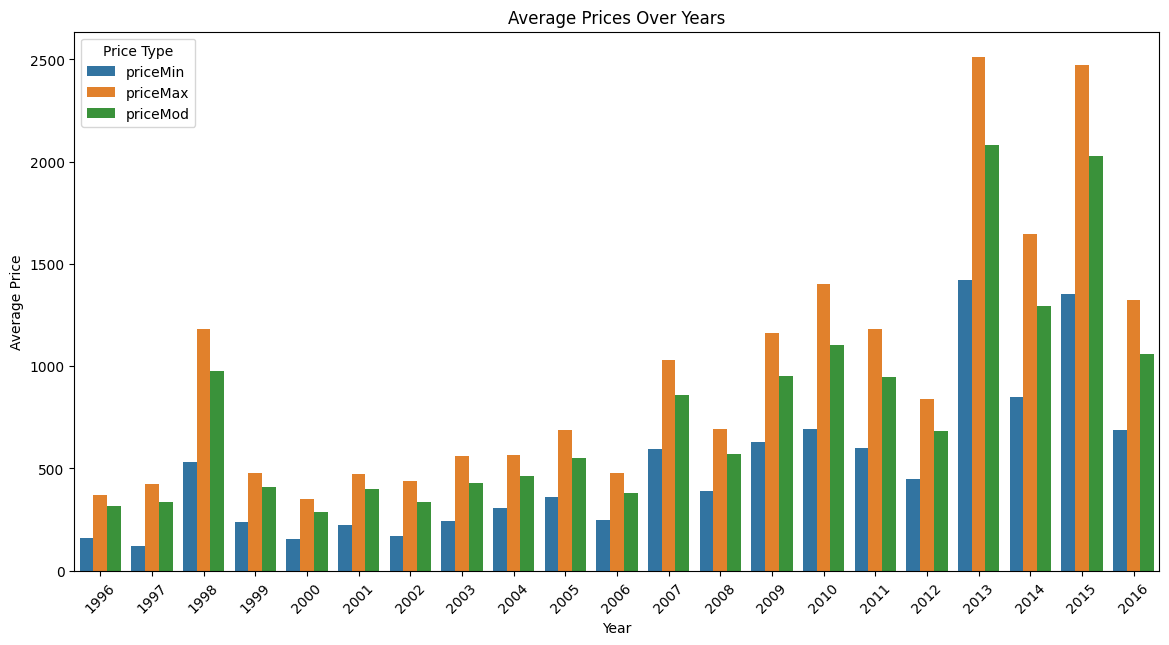

In [49]:
# Bar Plot
yearly_avg = data.groupby('year')[['priceMin', 'priceMax', 'priceMod']].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(x='year', y='value', hue='variable', data=yearly_avg.melt(id_vars='year'))
plt.title('Average Prices Over Years')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend(title='Price Type')
plt.xticks(rotation=45)
plt.show()

<h4>Average prices for each month to see if there's a seasonal pattern.</h4>

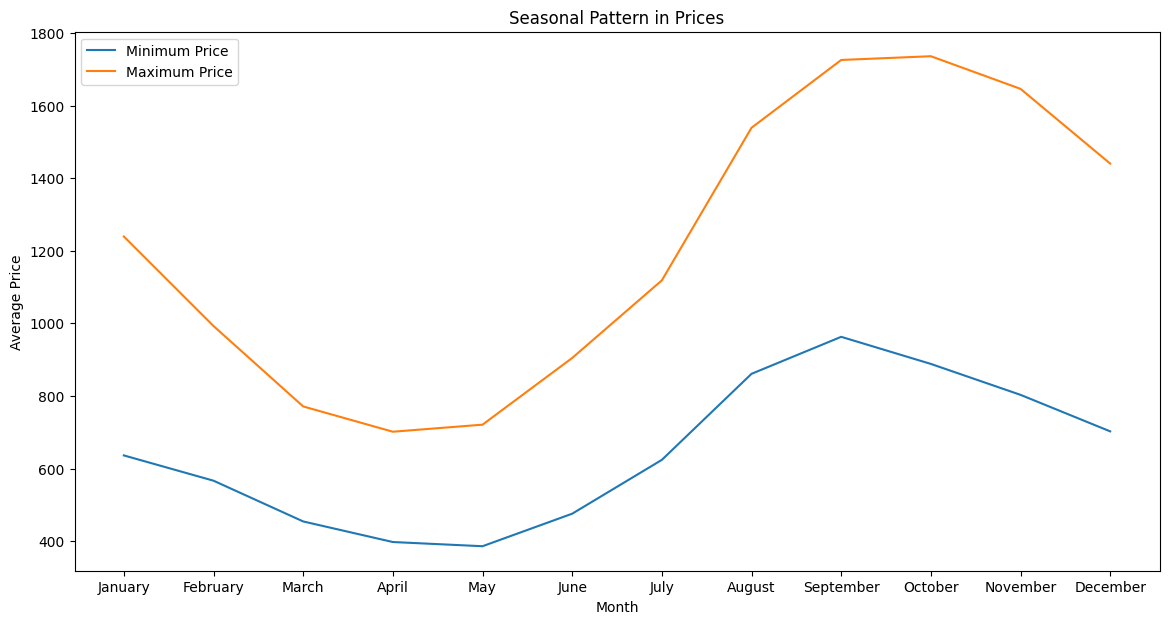

In [50]:
data_encoded['month'] = data_encoded.index.month

# Group by month and calculate the average prices
monthly_avg = data_encoded.groupby('month')[['priceMin', 'priceMax']].mean()

# Convert index to datetime object
monthly_avg.index = pd.to_datetime(monthly_avg.index, format='%m')

# Extract month names from the datetime index
monthly_avg.index = monthly_avg.index.strftime('%B')

# Plotting the seasonal pattern
plt.figure(figsize=(14, 7))
plt.plot(monthly_avg.index, monthly_avg['priceMin'], label='Minimum Price')
plt.plot(monthly_avg.index, monthly_avg['priceMax'], label='Maximum Price')

plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Seasonal Pattern in Prices')
plt.legend()
plt.show()

<h3>Trend Analysis</h3>
I will use rolling means to smooth the time series data and visualize long-term trends.

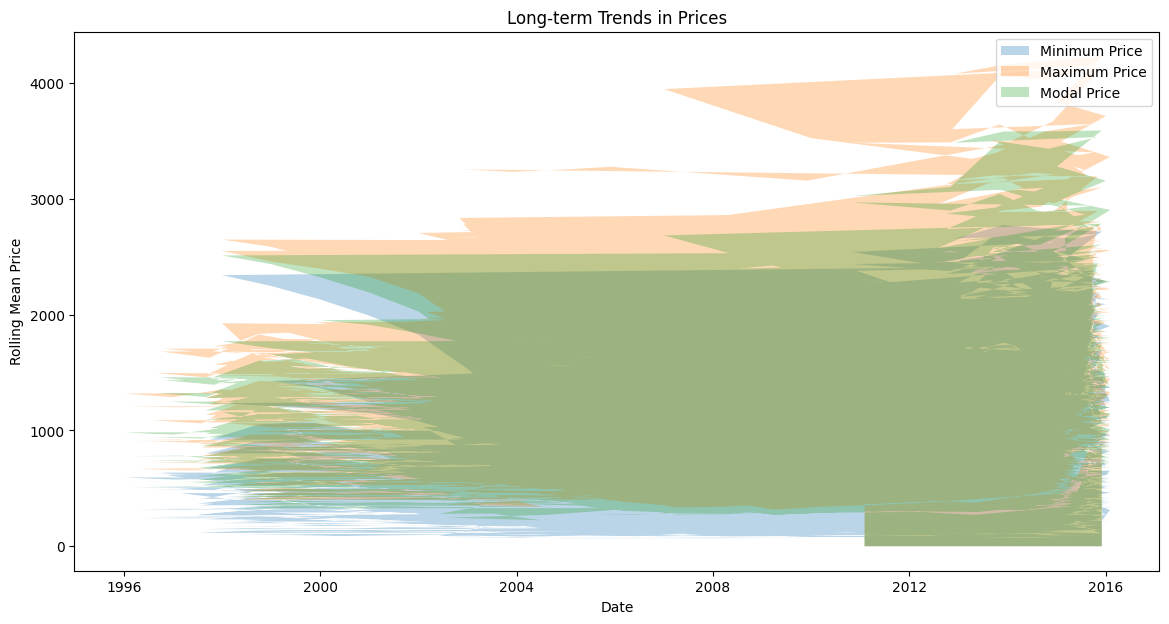

In [51]:
# Calculate rolling means
data_encoded['priceMin_roll'] = data_encoded['priceMin'].rolling(window=12).mean()
data_encoded['priceMax_roll'] = data_encoded['priceMax'].rolling(window=12).mean()
data_encoded['priceMod_roll'] = data_encoded['priceMod'].rolling(window=12).mean()

# Plotting the rolling means using an area plot
plt.figure(figsize=(14, 7))

# Plotting the area for the rolling mean of Minimum Price
plt.fill_between(data_encoded.index, data_encoded['priceMin_roll'], label='Minimum Price', alpha=0.3)

# Plotting the area for the rolling mean of Maximum Price
plt.fill_between(data_encoded.index, data_encoded['priceMax_roll'], label='Maximum Price', alpha=0.3)

# Plotting the area for the rolling mean of Modal Price
plt.fill_between(data_encoded.index, data_encoded['priceMod_roll'], label='Modal Price', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Rolling Mean Price')
plt.title('Long-term Trends in Prices')
plt.legend()
plt.show()


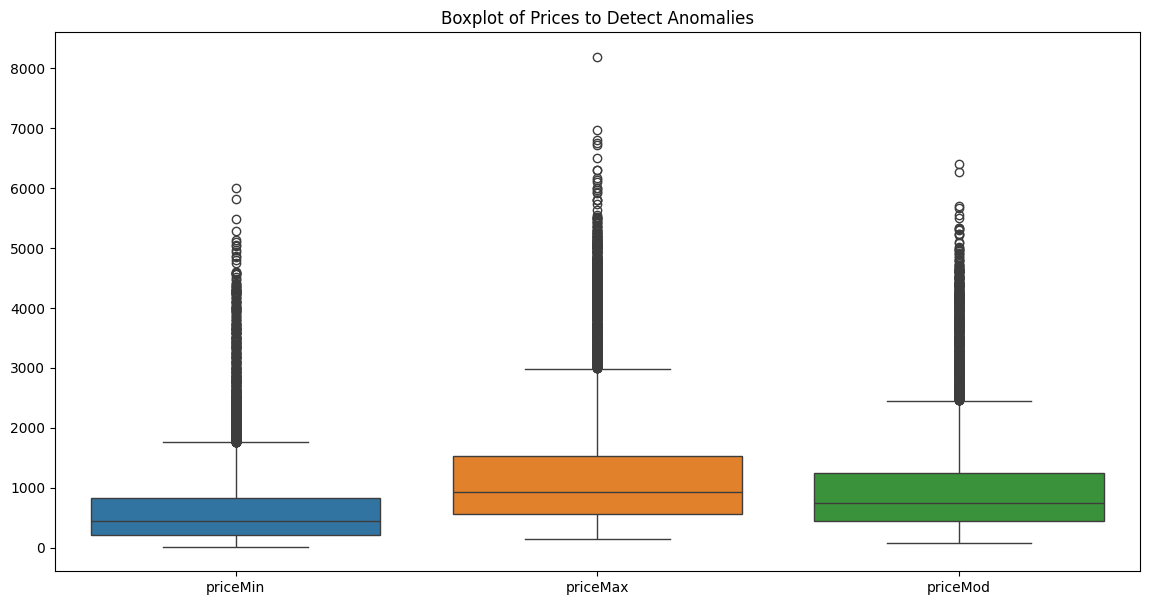

In [52]:
# Boxplot to identify anomalies
plt.figure(figsize=(14, 7))
sns.boxplot(data=data_encoded[['priceMin', 'priceMax', 'priceMod']])
plt.title('Boxplot of Prices to Detect Anomalies')
plt.show()

In [53]:
data

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2005-01-01,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR
2006-01-01,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR
2010-01-01,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR
2011-01-01,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR
2012-01-01,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR
...,...,...,...,...,...,...,...,...,...
2011-12-01,YEOLA(MS),December,2011,131326,282,612,526,MS,YEOLA
2012-12-01,YEOLA(MS),December,2012,207066,485,1327,1136,MS,YEOLA
2013-12-01,YEOLA(MS),December,2013,215883,472,1427,1177,MS,YEOLA


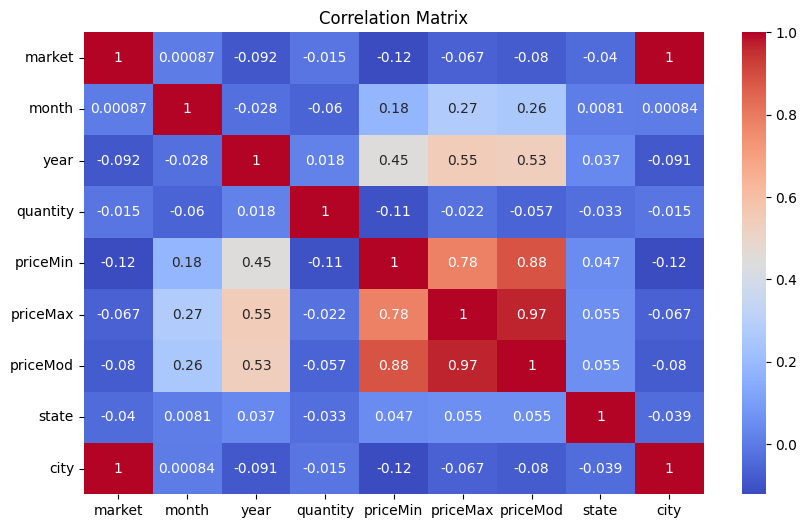

In [54]:
# Encode categorical variables
le_market = LabelEncoder()
data['market'] = le_market.fit_transform(data['market'])
le_state = LabelEncoder()
data['state'] = le_state.fit_transform(data['state'])
le_city = LabelEncoder()
data['city'] = le_city.fit_transform(data['city'])

# Convert month column to numeric
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['month'] = data['month'].apply(lambda x: months.index(x) + 1)

# Convert year column to numeric if it's not already
data['year'] = pd.to_numeric(data['year'])

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<h3>Feature Engineering</h3>

In [79]:
# Lagged Variables
data['priceMin_lagged'] = data['priceMin'].shift(1)
data['priceMax_lagged'] = data['priceMax'].shift(1)

# Rolling Statistics
data['priceMin_roll_mean'] = data['priceMin'].rolling(window=7).mean()
data['priceMax_roll_mean'] = data['priceMax'].rolling(window=7).mean()

# Seasonal Indicators
data['day_of_week'] = data.index.dayofweek

# Drop rows with NaN values resulting from lagged variables and rolling statistics
data.dropna(inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Define the exogenous variables
exog_train = train_data[['priceMin_lagged', 'priceMax_lagged', 'priceMin_roll_mean', 'priceMax_roll_mean', 'day_of_week']]
exog_test = test_data[['priceMin_lagged', 'priceMax_lagged', 'priceMin_roll_mean', 'priceMax_roll_mean', 'day_of_week']]

# Display the first few rows of train_data to verify the inclusion of new columns
print(train_data.head())



            market  month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                      
2012-02-01       0      2  2012       675       510       650       570   
2013-02-01       0      2  2013       845      1400      1843      1629   
2014-02-01       0      2  2014      1115       831      1163       983   
2015-02-01       0      2  2015      1115      1200      1946      1688   
2005-03-01       0      3  2005       900       281       357       322   

            state  city  priceMin_lagged  priceMax_lagged  priceMin_roll_mean  \
date                                                                            
2012-02-01     16     0            950.0           1400.0          795.142857   
2013-02-01     16     0            510.0            650.0          848.714286   
2014-02-01     16     0           1400.0           1843.0          780.428571   
2015-02-01     16     0            831.0           1163.0          91

In [57]:
total_data_points = data_encoded.shape[0]
print("Total data points in the data_encoded DataFrame:", total_data_points)


Total data points in the data_encoded DataFrame: 10227


In [77]:
# Print the columns of the train_data DataFrame
print(train_data.columns)


Index(['month', 'year', 'quantity', 'priceMin', 'priceMax', 'priceMod',
       'market_ABOHAR(PB)', 'market_AGRA(UP)', 'market_AHMEDABAD(GUJ)',
       'market_AHMEDNAGAR(MS)',
       ...
       'city_SURAT', 'city_TRIVENDRUM', 'city_UDAIPUR', 'city_UJJAIN',
       'city_VANI', 'city_VARANASI', 'city_YEOLA', 'priceMin_roll',
       'priceMax_roll', 'priceMod_roll'],
      dtype='object', length=267)


In [80]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Define exogenous variables
exog_train = train_data[['priceMin_lagged', 'priceMax_lagged', 'priceMin_roll_mean', 'priceMax_roll_mean', 'day_of_week']]
exog_test = test_data[['priceMin_lagged', 'priceMax_lagged', 'priceMin_roll_mean', 'priceMax_roll_mean', 'day_of_week']]

# Define the order and seasonal_order parameters for ARIMA and SARIMA models
order = (5, 1, 0)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S)

# Fit ARIMA model
arima_model = ARIMA(train_data['quantity'], exog=exog_train, order=order)
arima_result = arima_model.fit()

# Fit SARIMA model
sarima_model = SARIMAX(train_data['quantity'], exog=exog_train, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Forecast with ARIMA
arima_forecast = arima_result.forecast(steps=len(test_data), exog=exog_test)

# Forecast with SARIMA
sarima_forecast = sarima_result.forecast(steps=len(test_data), exog=exog_test)

# Evaluate performance
arima_mse = mean_squared_error(test_data['quantity'], arima_forecast)
sarima_mse = mean_squared_error(test_data['quantity'], sarima_forecast)

print("ARIMA MSE:", arima_mse)
print("SARIMA MSE:", sarima_mse)

# Choose the best model based on MSE
best_model = "ARIMA" if arima_mse < sarima_mse else "SARIMA"
print("Best Model:", best_model)


C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\acer\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting

ARIMA MSE: 7669771056.990435
SARIMA MSE: 20924619524.770756
Best Model: ARIMA
